In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [2]:
# read raw data
raw = pd.read_csv('https://github.com/SamEdwardes/ufc-data/raw/master/event_details.csv')
raw['date'] = pd.to_datetime(raw['date'])

In [3]:
# assign event ids
event_names = raw.sort_values(by='date')['event_name'].unique()
mapper_event_to_eventid = pd.DataFrame(data={'event_name': event_names, 'event_id': np.arange(1, len(event_names) + 1)})
mapper_event_to_eventid.index = mapper_event_to_eventid['event_id'].values
# mapper_event_to_eventid

In [4]:
df = raw.copy()
df['fight_id'] = df.index
df['event_id'] = pd.merge(df[['event_name']], mapper_event_to_eventid, how='left', on='event_name')['event_id']

##########################################################
# shuffle the order of fighers. UFC always has the winning figher as fighter 1
##########################################################
df['blue'] = np.random.choice(a=[1, 2], p=[0.5, 0.5], size=df.shape[0])
df['red'] = df['blue'].apply(lambda x: 1 if x == 2 else 2)
df['winner_colour'] = df['blue'].apply(lambda x: "blue" if x == 1 else "red")
df['blue'] = df.apply(lambda x: x['fighter_1_name'] if x['blue'] == 1 else x['fighter_2_name'], axis=1)
df['red'] = df.apply(lambda x: x['fighter_1_name'] if x['red'] == 1 else x['fighter_2_name'], axis=1)
df['winner_name'] = df.apply(lambda x: x['blue'] if x['winner_colour'] == "blue"  else x['red'], axis=1)


##########################################################
# pivot longers so that each row is only 1 fighter
##########################################################

cols_to_pivot = ['fighter_1_name', 'fighter_2_name']

df_long = df.melt(
    value_vars=cols_to_pivot,
    id_vars=[i for i in df.columns if i not in cols_to_pivot],
    value_name="fighter_name", var_name="fighter_number"
)

df_long['fighter_number'] = df_long['fighter_number'].str.replace("_name", "")
df_long['colour'] = df_long.apply(lambda x: 'blue' if x['blue'] == x['fighter_name'] else 'red', axis=1)
df_long['opponent_name'] = df_long.apply(lambda x: x['blue'] if x['red'] == x['fighter_name'] else x['red'], axis=1)
df_long['str'] = df_long.apply(lambda x: x['fighter_1_str'] if x['fighter_number'] == 'fighter_1' else  x['fighter_2_str'], axis=1)
df_long['td'] = df_long.apply(lambda x: x['fighter_1_td'] if x['fighter_number'] == 'fighter_1' else  x['fighter_2_td'], axis=1)
df_long['sub'] = df_long.apply(lambda x: x['fighter_1_sub'] if x['fighter_number'] == 'fighter_1' else  x['fighter_2_sub'], axis=1)
df_long['pass'] = df_long.apply(lambda x: x['fighter_1_pass'] if x['fighter_number'] == 'fighter_1' else  x['fighter_2_pass'], axis=1)

df_long['winner'] = df_long.apply(lambda x: 1 if x['winner_colour'] == x['colour'] else 0, axis=1)
df_long['loser'] = df_long.apply(lambda x: 1 if x['winner_colour'] != x['colour'] else 0, axis=1)
df_long['blue_win'] = df_long['winner_colour'].apply(lambda x: 1 if x == 'blue' else 0)

df_long = df_long[['event_name', 'event_id', 'date', 'weight_class', 'win_method', 'win_round', 'win_time',
                   'fight_id', 'fighter_name', 'fighter_number', 'colour', 'str', 'td', 'sub', 'pass', 
                   'winner', 'loser', 'blue_win']]

##########################################################
# Calculate running total stats for each fighter
##########################################################

def win_method_binner(x):
    """Categorize win methods into bins."""
    if "DEC" in x:
        return "DEC"
    elif "TKO" in x:
        return "TKO"
    elif "SUB" in x:
        return "SUB"
    elif "Overturned" in x:
        return "Overturned"
    else:
        return x

# calculate running total stats for the fighers.
# Ideas for features:
# wins, loss, TKO, TKO received, days since last fight, height, weight, wing_span, win streak, loss streak, last fight time
df_long = df_long.sort_values(by=['fighter_name', 'date'])
df_long = df_long.reset_index(drop=True)
df_long['win_method_bin'] = df_long['win_method'].apply(win_method_binner)
df_long['num_fights'] = df_long.groupby('fighter_name')['event_name'].cumcount()
df_long['wins'] = df_long.groupby('fighter_name')['winner'].cumsum()
df_long['wins'] = df_long.groupby('fighter_name')['wins'].shift().fillna(0).astype(int)
df_long['losses'] = df_long.groupby('fighter_name')['loser'].cumsum()
df_long['losses'] = df_long.groupby('fighter_name')['losses'].shift().fillna(0).astype(int)
df_long['days_since_last_fight'] = df_long.groupby('fighter_name')['date'].diff().dt.days.fillna(0)
df_long['tko_recieved'] = df_long.apply(lambda x: 1 if x['winner'] == 0 and x['win_method_bin'] == "TKO" else 0, axis=1)
df_long['total_tko_recieved'] = df_long.groupby('fighter_name')['tko_recieved'].cumsum()
df_long['total_tko_recieved'] = df_long.groupby('fighter_name')['total_tko_recieved'].shift().fillna(0).astype(int)
df_long['fight_time'] = df_long.apply(lambda x: (x['win_round'] - 1) * 5 + float(x['win_time'][-2])/60 + float(x['win_time'][0]), axis=1)
df_long['total_octagon_time'] = df_long.groupby('fighter_name')['fight_time'].cumsum()
df_long['total_octagon_time'] = df_long.groupby('fighter_name')['total_octagon_time'].shift().fillna(0)
df_long['last_fight_time'] = df_long.groupby('fighter_name')['fight_time'].shift(periods=1).fillna(0)
df_long['last_fight_tko_received'] = df_long.groupby('fighter_name')['tko_recieved'].shift(periods=1).fillna(0).astype(int)
df_long['last_fight_win'] = df_long.groupby('fighter_name')['winner'].shift(periods=1).fillna(0).astype(int)
df_long['last_fight_loss'] = df_long.groupby('fighter_name')['loser'].shift(periods=1).fillna(0).astype(int)
# df_long['win_streak'] = np.NaN
# df_long['loss_streak'] = np.NaN


print(df.shape)
print(df_long.shape)
df_long.query("fighter_name == 'Donald Cerrone'")

(5596, 26)
(11192, 31)


,event_name,event_id,date,weight_class,win_method,win_round,win_time,fight_id,fighter_name,fighter_number,colour,str,td,sub,pass,winner,loser,blue_win,win_method_bin,num_fights,wins,losses,days_since_last_fight,tko_recieved,total_tko_recieved,fight_time,total_octagon_time,last_fight_time,last_fight_tko_received,last_fight_win,last_fight_loss
2947,UFC_126-Silva_vs_Belfort,169,2011-02-05,Lightweight,"SUB, Rear, Naked, Choke",2,3:48,4042,Donald Cerrone,fighter_1,blue,37.0,3.0,1.0,7.0,1,0,1,SUB,0,0,0,0.0,0,0,8.066667,0.000000,0.000000,0,0,0
2948,UFC_131-Dos_Santos_vs_Carwin,177,2011-06-11,Lightweight,U-DEC,3,5:00,3949,Donald Cerrone,fighter_1,blue,86.0,0.0,0.0,0.0,1,0,1,DEC,1,1,0,126.0,0,0,15.000000,8.066667,8.066667,0,1,0
2949,UFC_Live-Hardy_vs_Lytle,181,2011-08-14,Lightweight,"KO/TKO, Punches",1,3:01,3902,Donald Cerrone,fighter_1,red,30.0,0.0,0.0,0.0,1,0,0,TKO,2,2,0,64.0,0,0,3.000000,23.066667,15.000000,0,1,0
2950,UFC_137-Penn_vs_Diaz,187,2011-10-29,Lightweight,"SUB, Rear, Naked, Choke",1,2:22,3839,Donald Cerrone,fighter_1,red,9.0,0.0,1.0,1.0,1,0,0,SUB,3,3,0,76.0,0,0,2.033333,26.066667,3.000000,0,1,0
2951,UFC_141-Lesnar_vs_Overeem,193,2011-12-30,Lightweight,U-DEC,3,5:00,3771,Donald Cerrone,fighter_2,blue,96.0,0.0,0.0,0.0,0,1,0,DEC,4,4,0,62.0,0,0,15.000000,28.100000,2.033333,0,1,0
2952,UFC_on_FUEL_TV-Korean_Zombie_vs_Poirier,204,2012-05-15,Lightweight,U-DEC,3,5:00,3651,Donald Cerrone,fighter_1,blue,87.0,1.0,0.0,0.0,1,0,1,DEC,5,4,1,137.0,0,0,15.000000,43.100000,15.000000,0,0,1
2953,UFC_150-Henderson_vs_Edgar_II,214,2012-08-11,Lightweight,"KO/TKO, Kick",1,1:16,3540,Donald Cerrone,fighter_1,red,4.0,0.0,0.0,0.0,1,0,0,TKO,6,5,1,88.0,0,0,1.016667,58.100000,15.000000,0,1,0
2954,UFC_on_FOX-Johnson_vs_Dodson,226,2013-01-26,Lightweight,"KO/TKO, Kick",1,2:35,3409,Donald Cerrone,fighter_2,red,4.0,0.0,0.0,0.0,0,1,1,TKO,7,6,1,168.0,1,0,2.050000,59.116667,1.016667,0,1,0
2955,UFC_160-Velasquez_vs_Silva_2,237,2013-05-25,Lightweight,U-DEC,3,5:00,3280,Donald Cerrone,fighter_1,blue,78.0,4.0,0.0,4.0,1,0,1,DEC,8,6,2,119.0,0,1,15.000000,61.166667,2.050000,1,0,1
2956,UFC_Fight_Night-Condit_vs_Kampmann_2,244,2013-08-28,Lightweight,U-DEC,3,5:00,3194,Donald Cerrone,fighter_2,red,40.0,1.0,0.0,1.0,0,1,1,DEC,9,7,2,95.0,0,1,15.000000,76.166667,15.000000,0,1,0


In [5]:
##########################################################
# Pivot wider so that each fight is only 1 row
##########################################################

tmp = df_long.pivot_table(index=['fight_id', 'colour']).unstack()
tmp = tmp[['wins', 'losses', 'total_octagon_time', 'total_tko_recieved', 'days_since_last_fight', 
         'last_fight_tko_received', 'last_fight_win', 'last_fight_loss', 'last_fight_time', 'blue_win']]
tmp.columns = ['_'.join(col).strip() for col in tmp.columns.values]
tmp['blue_win'] = tmp['blue_win_blue']
tmp = tmp.drop(columns=['blue_win_blue', 'blue_win_red'])
tmp = tmp.reset_index()

data = pd.merge(df, tmp, how='left', on='fight_id')
data = data.sort_values(by=['event_id', 'fight_id'])

In [6]:
# double check everything matches
df_long.query("fight_id == 0 or fight_id == 99").sort_values(by='fight_id')

,event_name,event_id,date,weight_class,win_method,win_round,win_time,fight_id,fighter_name,fighter_number,colour,str,td,sub,pass,winner,loser,blue_win,win_method_bin,num_fights,wins,losses,days_since_last_fight,tko_recieved,total_tko_recieved,fight_time,total_octagon_time,last_fight_time,last_fight_tko_received,last_fight_win,last_fight_loss
421,UFC_Fight_Night-Overeem_vs_Harris,516,2020-05-16,Heavyweight,"KO/TKO, Punches",2,3:00,0,Alistair Overeem,fighter_1,red,68.0,1.0,0.0,3.0,1,0,0,TKO,17,10,7,161.0,0,7,8.000000,142.616667,24.083333,1,0,1
10894,UFC_Fight_Night-Overeem_vs_Harris,516,2020-05-16,Heavyweight,"KO/TKO, Punches",2,3:00,0,Walt Harris,fighter_2,blue,25.0,0.0,0.0,0.0,0,1,0,TKO,13,6,7,301.0,1,2,8.000000,80.466667,0.016667,0,1,0
274,UFC_247-Jones_vs_Reyes,508,2020-02-08,Welterweight,"KO/TKO, Punch",1,0:27,99,Alex Morono,fighter_2,blue,1.0,0.0,0.0,0.0,0,1,0,TKO,9,7,2,119.0,1,0,0.033333,105.066667,15.000000,0,1,0
6264,UFC_247-Jones_vs_Reyes,508,2020-02-08,Welterweight,"KO/TKO, Punch",1,0:27,99,Khaos Williams,fighter_1,red,10.0,0.0,0.0,0.0,1,0,0,TKO,0,0,0,0.0,0,0,0.033333,0.000000,0.000000,0,0,0


In [7]:
data.query("fight_id == 0 or fight_id == 99")

,event_name,date,fighter_1_name,fighter_2_name,fighter_1_url,fighter_2_url,fighter_1_str,fighter_2_str,fighter_1_td,fighter_2_td,fighter_1_sub,fighter_2_sub,fighter_1_pass,fighter_2_pass,weight_class,win_method,win_round,win_time,winner,fight_url,fight_id,event_id,blue,red,winner_colour,winner_name,wins_blue,wins_red,losses_blue,losses_red,total_octagon_time_blue,total_octagon_time_red,total_tko_recieved_blue,total_tko_recieved_red,days_since_last_fight_blue,days_since_last_fight_red,last_fight_tko_received_blue,last_fight_tko_received_red,last_fight_win_blue,last_fight_win_red,last_fight_loss_blue,last_fight_loss_red,last_fight_time_blue,last_fight_time_red,blue_win
99,UFC_247-Jones_vs_Reyes,2020-02-08,Khaos Williams,Alex Morono,http://www.ufcstats.com/fighter-details/2558ae...,http://www.ufcstats.com/fighter-details/cdb96a...,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Welterweight,"KO/TKO, Punch",1,0:27,fighter_1,http://www.ufcstats.com/fight-details/ed499508...,99,508,Alex Morono,Khaos Williams,red,Khaos Williams,7,0,2,0,105.066667,0.000000,0,0,119.0,0.0,0,0,1,0,0,0,15.000000,0.000000,0
0,UFC_Fight_Night-Overeem_vs_Harris,2020-05-16,Alistair Overeem,Walt Harris,http://www.ufcstats.com/fighter-details/b4ad3a...,http://www.ufcstats.com/fighter-details/03f982...,68.0,25.0,1.0,0.0,0.0,0.0,3.0,0.0,Heavyweight,"KO/TKO, Punches",2,3:00,fighter_1,http://www.ufcstats.com/fight-details/ce074851...,0,516,Walt Harris,Alistair Overeem,red,Alistair Overeem,6,10,7,7,80.466667,142.616667,2,7,301.0,161.0,0,1,1,0,0,1,0.016667,24.083333,0


## Test Model

In [8]:
selected_cols = [
    # numeric
    'wins_blue',
    'wins_red',
    'losses_blue',
    'losses_red',
    'total_octagon_time_blue',
    'total_octagon_time_red',
    'total_tko_recieved_blue',
    'total_tko_recieved_red',
    'days_since_last_fight_blue',
    'days_since_last_fight_red',
    'last_fight_time_blue',
    'last_fight_time_red', 
    # categorical
    'last_fight_tko_received_blue',
    'last_fight_tko_received_red',
    'last_fight_win_blue',
    'last_fight_win_red',
    'last_fight_loss_blue',
    'last_fight_loss_red',

]
cols_to_standard_scale = [
    'wins_blue',
    'wins_red',
    'losses_blue',
    'losses_red',
    'total_octagon_time_blue',
    'total_octagon_time_red',
    'total_tko_recieved_blue',
    'total_tko_recieved_red',
    'days_since_last_fight_blue',
    'days_since_last_fight_red',
    'last_fight_time_blue',
    'last_fight_time_red'
]

In [9]:
%%time
results = defaultdict(list)
train_events = []
for i in np.arange(1, max(mapper_event_to_eventid['event_id'])):
# for i in np.arange(1, 5):
    train_events.append(i)
    test_event = i + 1
    
    # split data    
    X = data[selected_cols + ['fight_id' ,'event_id']]
    X_train = X.query('event_id in @train_events').drop(columns=['fight_id', 'event_id'])
    X_test =  X.query('event_id == @test_event').drop(columns=['event_id'])
    X_test_fight_id = X_test['fight_id']
    X_test = X_test.drop(columns='fight_id')
    
    Y = data[['blue_win'] + ['fight_id' ,'event_id']] 
    y_train = Y.query('event_id in @train_events')['blue_win'].ravel()
    y_test = Y.query('event_id == @test_event')['blue_win'].ravel()
    
    # preprocess data
    scaler = StandardScaler()
    X_train[cols_to_standard_scale] = scaler.fit_transform(X_train[cols_to_standard_scale])
    X_test[cols_to_standard_scale] = scaler.transform(X_test[cols_to_standard_scale])
    
    # model
    lr = LogisticRegression().fit(X_train, y_train)
    
    # results
    results['test_event_id'].append(i)
    results['num_train_events'].append(i)
    results['num_train_fights'].append(X_train.shape[0])
    results['num_test_fights'].append(X_test.shape[0])
    results['train_accuracy'].append(lr.score(X_train, y_train))
    results['test_accuracy'].append(lr.score(X_test, y_test))
    results['coef'].append(lr.coef_.round(2)[0])
    
    # save the detailed results
    results_test = pd.DataFrame(data={
        'fight_id': X_test_fight_id,
        'blue_win': y_test,
        'prediction': lr.predict(X_test),
        'prediction_prob_win': lr.predict_proba(X_test)[:,1]
    })
    results_test['split'] = 'test'
    results_test['correct'] = results_test.apply(lambda x: 1 if x['blue_win'] == x['prediction'] else 0, axis=1)

    df_final = pd.merge(data.query('event_id == @test_event'), results_test.drop(columns=['blue_win']), 
                        how='left', left_on='fight_id', right_on='fight_id')
    df_final['predicted_winner'] = df_final.apply(lambda x: x['blue'] if x['prediction'] == 1 else x['red'] , axis=1)

    df_final = df_final[[
        'event_name', 'event_id', 'fight_id', 'date', 'blue', 'red', 'winner_colour', 'winner_name', 'predicted_winner', 'correct', 'win_method'
    ] + selected_cols + [                       
        'blue_win', 'prediction', 'prediction_prob_win', 'split'
    ]]

    results['details'].append(df_final)


CPU times: user 1min 44s, sys: 1.25 s, total: 1min 45s
Wall time: 27.4 s


Mean: 0.56 

Quantiles:
0.25    0.454545
0.50    0.571429
0.75    0.666667
0.99    0.898444
Name: test_accuracy, dtype: float64



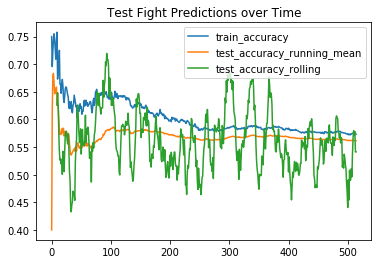

In [10]:
results_df = pd.DataFrame(results)
results_df['test_accuracy_running_mean'] = results_df['test_accuracy'].cumsum() / results_df['num_train_events']
results_df['test_accuracy_rolling'] = results_df[['test_accuracy']].rolling(10).mean()
# results_df

results_df[['train_accuracy', 
#             'test_accuracy',
            'test_accuracy_running_mean', 
            'test_accuracy_rolling']].plot.line(title="Test Fight Predictions over Time")

print("Mean:", results_df.test_accuracy.mean().round(2), "\n")
print("Quantiles:", results_df.test_accuracy.quantile([0.25, 0.5, 0.75, 0.99]), sep="\n")
print("")

## Explore some of the results

In [11]:
# results_df

In [12]:
i = 506
print("Accuracy:", round(results['test_accuracy'][i],1), end="\n")
print(pd.DataFrame(data=results['coef'][i], index=selected_cols, columns=['coef']))

results['details'][i].round(2)

Accuracy: 0.6
                              coef
wins_blue                     0.39
wins_red                     -0.33
losses_blue                  -0.18
losses_red                    0.20
total_octagon_time_blue      -0.15
total_octagon_time_red        0.02
total_tko_recieved_blue      -0.09
total_tko_recieved_red        0.12
days_since_last_fight_blue   -0.03
days_since_last_fight_red     0.08
last_fight_time_blue          0.06
last_fight_time_red          -0.07
last_fight_tko_received_blue  0.01
last_fight_tko_received_red  -0.05
last_fight_win_blue           0.55
last_fight_win_red           -0.34
last_fight_loss_blue          0.46
last_fight_loss_red          -0.31


,event_name,event_id,fight_id,date,blue,red,winner_colour,winner_name,predicted_winner,correct,win_method,wins_blue,wins_red,losses_blue,losses_red,total_octagon_time_blue,total_octagon_time_red,total_tko_recieved_blue,total_tko_recieved_red,days_since_last_fight_blue,days_since_last_fight_red,last_fight_time_blue,last_fight_time_red,last_fight_tko_received_blue,last_fight_tko_received_red,last_fight_win_blue,last_fight_win_red,last_fight_loss_blue,last_fight_loss_red,blue_win,prediction,prediction_prob_win,split
0,UFC_247-Jones_vs_Reyes,508,92,2020-02-08,Dominick Reyes,Jon Jones,red,Jon Jones,Jon Jones,1,U-DEC,6,19,0,2,36.23,310.45,0,0,113.0,217.0,1.07,25.00,0,0,1,1,0,0,0,0,0.28,test
1,UFC_247-Jones_vs_Reyes,508,93,2020-02-08,Katlyn Chookagian,Valentina Shevchenko,red,Valentina Shevchenko,Valentina Shevchenko,1,"KO/TKO, Punches",6,7,2,2,120.00,153.10,0,0,98.0,182.0,15.00,25.00,0,0,1,1,0,0,0,0,0.44,test
2,UFC_247-Jones_vs_Reyes,508,94,2020-02-08,Justin Tafa,Juan Adams,blue,Justin Tafa,Justin Tafa,1,"KO/TKO, Punch",0,1,1,2,2.02,25.15,1,1,126.0,203.0,2.02,0.07,1,1,0,0,1,1,1,1,0.51,test
3,UFC_247-Jones_vs_Reyes,508,95,2020-02-08,Mirsad Bektic,Dan Ige,red,Dan Ige,Dan Ige,1,S-DEC,6,4,2,1,73.20,46.10,2,0,210.0,231.0,4.03,15.00,1,0,0,1,1,0,0,0,0.43,test
4,UFC_247-Jones_vs_Reyes,508,96,2020-02-08,Ilir Latifi,Derrick Lewis,red,Derrick Lewis,Derrick Lewis,1,U-DEC,7,13,5,5,85.33,165.73,3,4,182.0,98.0,9.05,15.00,1,0,0,1,1,0,0,0,0.40,test
5,UFC_247-Jones_vs_Reyes,508,97,2020-02-08,James Krause,Trevin Giles,red,Trevin Giles,James Krause,0,S-DEC,8,2,3,2,119.23,44.18,1,0,84.0,189.0,14.02,11.07,0,0,1,0,0,1,0,1,0.59,test
6,UFC_247-Jones_vs_Reyes,508,98,2020-02-08,Andrea Lee,Lauren Murphy,red,Lauren Murphy,Andrea Lee,0,S-DEC,3,3,1,4,60.00,100.15,0,0,154.0,189.0,15.00,11.07,0,0,0,1,1,0,0,1,0.57,test
7,UFC_247-Jones_vs_Reyes,508,99,2020-02-08,Alex Morono,Khaos Williams,red,Khaos Williams,Alex Morono,0,"KO/TKO, Punch",7,0,2,0,105.07,0.00,0,0,119.0,0.0,15.00,0.00,0,0,1,0,0,0,0,1,0.69,test
8,UFC_247-Jones_vs_Reyes,508,100,2020-02-08,Mario Bautista,Miles Johns,blue,Mario Bautista,Miles Johns,0,"KO/TKO, Flying, Knee",1,1,1,0,18.05,15.00,0,0,203.0,147.0,15.00,15.00,0,0,1,1,0,0,1,0,0.48,test
9,UFC_247-Jones_vs_Reyes,508,101,2020-02-08,Journey Newson,Domingo Pilarte,red,Domingo Pilarte,Domingo Pilarte,1,"Overturned, Punch",0,0,1,1,15.00,15.00,0,0,224.0,203.0,15.00,15.00,0,0,0,0,1,1,0,0,0.50,test


## Predict the next UFC fight...

In [13]:
#